0. IMPORTS

In [11]:
# ===========================================
# 0. IMPORTS
# ===========================================
# Import the 'os' module for interacting with the operating system (e.g., file paths)
import os
# Import the 'glob' module for finding files using pattern matching (e.g., *.png)
import glob
# Import 'numpy' as 'np' for numerical operations and array manipulations
import numpy as np
# Import 'pyplot' from 'matplotlib' as 'plt' for creating plots and visualizations
import matplotlib.pyplot as plt
# Import the 'Image' class from the 'PIL' library for image loading and processing
from PIL import Image
# Import 'PCA' from scikit-learn for Principal Component Analysis dimensionality reduction
from sklearn.decomposition import PCA
# Import 'csr_matrix' for creating Compressed Sparse Row matrices (efficient for large sparse data)
from scipy.sparse import csr_matrix
# Import 'eigsh' for computing eigenvalues/vectors of large sparse matrices (ARPACK)
from scipy.sparse.linalg import eigsh
# Import 'zoom' for image resizing/interpolation using SciPy's ndimage module
from scipy.ndimage import zoom
# Import the 'warnings' module to handle warning messages
import warnings
# Suppress all warning messages to keep output clean (use with caution in development)
warnings.filterwarnings('ignore')

1. LOAD AND PREPROCESS DATA

In [13]:
# ===========================================
# 1. LOAD AND PREPROCESS DATA
# ===========================================
def load_unbiased_simple(base_path, max_samples=4000, random_seed=42):
    """
    Minimal unbiased loading for α validation.
    Loads and balances image data from GaoFen, Sentinel, and other sources.
    Returns flattened image arrays (X) and corresponding label data (Y).
    """
    import random
    
    # Get all JPG files in the directory
    all_files = sorted(glob.glob(os.path.join(base_path, '*.jpg')))
    print(f"Total files: {len(all_files)}")
    
    # Filter out very small files (likely corrupted or incomplete)
    filtered_files = []
    for f in all_files:
        if os.path.getsize(f) / 1024 > 5.0:  # > 5KB
            filtered_files.append(f)
    
    print(f"After size filter: {len(filtered_files)} files")
    
    # Categorize images by filename prefix into 3 groups
    groups = {'Gaofen': [], 'Sentinel': [], 'Other': []}
    
    for f in filtered_files:
        basename = os.path.basename(f)
        if basename.startswith('Gao'):
            groups['Gaofen'].append(f)
        elif basename.startswith('Sen'):
            groups['Sentinel'].append(f)
        else:
            groups['Other'].append(f)
    
    # Remove empty groups to avoid division issues
    groups = {k: v for k, v in groups.items() if v}
    
    # Balanced sampling: take equal number from each available group
    random.seed(random_seed)
    sampled_files = []
    samples_per_group = max_samples // len(groups)
    
    for group_name, files in groups.items():
        n_sample = min(samples_per_group, len(files))
        if n_sample > 0:
            sampled = random.sample(files, n_sample)
            sampled_files.extend(sampled)
            print(f"  {group_name}: {n_sample} samples")
    
    # If we still need more samples after balanced sampling, add random ones
    if len(sampled_files) < max_samples:
        remaining = max_samples - len(sampled_files)
        remaining_files = [f for f in filtered_files if f not in sampled_files]
        if remaining_files:
            extra = random.sample(remaining_files, min(remaining, len(remaining_files)))
            sampled_files.extend(extra)
    
    # Load image data and corresponding labels
    images = []
    labels = []
    
    for jpg_file in sampled_files:
        # Load image as grayscale, normalize to [0, 1]
        img = np.array(Image.open(jpg_file).convert('L'))
        img = img.astype(np.float32) / 255.0
        images.append(img.flatten())  # Flatten to 1D array
        
        # Try to load corresponding label from .txt file
        txt_file = jpg_file.replace('.jpg', '.txt')
        if os.path.exists(txt_file):
            with open(txt_file, 'r') as f:
                line = f.readline().strip().split()
                if len(line) == 5:
                    # Expecting format: class_id x_center y_center width height
                    labels.append([float(x) for x in line[1:]])
                else:
                    # Default bounding box if format doesn't match
                    labels.append([0.5, 0.5, 0.1, 0.1])
        else:
            # Default bounding box if no label file exists
            labels.append([0.5, 0.5, 0.1, 0.1])
    
    # Convert to numpy arrays
    X = np.array(images)
    Y = np.array(labels)
    
    # Print statistics about the loaded dataset
    print(f"\n✓ Loaded {X.shape[0]} images")
    print(f"✓ Data range: [{X.min():.3f}, {X.max():.3f}]")
    print(f"✓ Mean variance per image: {np.mean(np.var(X, axis=1)):.6f}")
    
    return X, Y

2. CONFIRMATION AND VISUALISATION OF DATASET

Loading Ship Dataset for α Validation
Total files: 39729
After size filter: 20963 files
  Gaofen: 1333 samples
  Sentinel: 1333 samples
  Other: 935 samples

✓ Loaded 4000 images
✓ Data range: [0.000, 1.000]
✓ Mean variance per image: 0.017384

DATA SUMMARY:
✓ Images shape: (4000, 65536)
✓ Labels shape: (4000, 4)
✓ Mean pixel value: 0.1237
✓ Std pixel value: 0.1668
✓ Sample variance range: [0.002299, 0.010535]


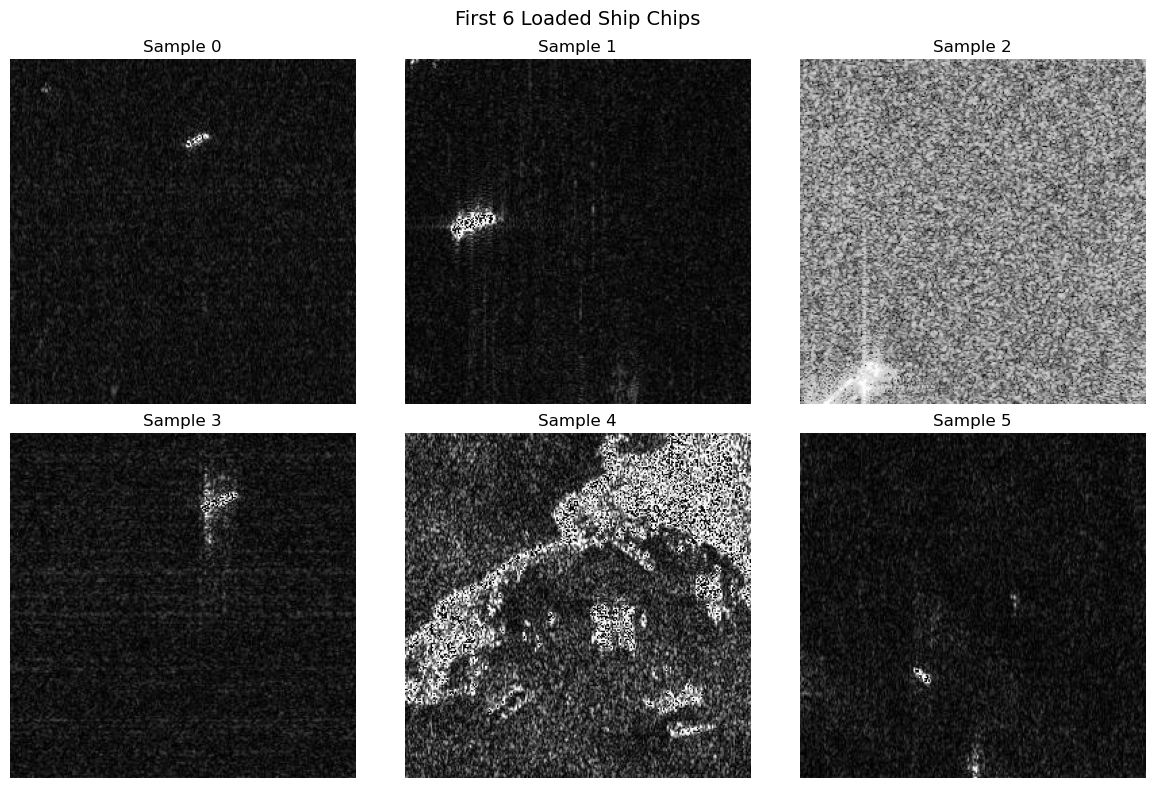


✓ Data loading complete. Ready for LCA experiments.


In [15]:
# ===========================================
# 2. CONFIRMATION AND VISUALISATION OF DATASET
# ===========================================
# Path to the ship dataset directory (Windows path with raw string)
SHIP_PATH = r"C:\Users\mayyu\OneDrive\VAC WORK\LCA\ship_dataset_v0"

# Print section header for clarity in console output
print("=" * 60)
print("Loading Ship Dataset for α Validation")
print("=" * 60)

# Actually CALL the function
# Load ship dataset using the previously defined function
# - max_samples=4000: Limit total samples to 4000 images
# - random_seed=42: Ensure reproducible sampling
X_ships, Y_ships = load_unbiased_simple(
    base_path=SHIP_PATH,
    max_samples=4000,
    random_seed=42
)

# Print dataset statistics after loading
print("\n" + "=" * 60)
print("DATA SUMMARY:")
print("=" * 60)
print(f"✓ Images shape: {X_ships.shape}")  # Should be (n_samples, 65536) for 256x256 images
print(f"✓ Labels shape: {Y_ships.shape}")  # Should be (n_samples, 4) for bounding box coordinates
print(f"✓ Mean pixel value: {np.mean(X_ships):.4f}")  # Average pixel intensity across all images
print(f"✓ Std pixel value: {np.std(X_ships):.4f}")    # Standard deviation of pixel values
# Show variance range of first and last image to check data consistency
print(f"✓ Sample variance range: [{np.var(X_ships[0]):.6f}, {np.var(X_ships[-1]):.6f}]")

# Quick visualization to confirm loading
# Create a 2x3 grid of subplots to display first 6 images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    if i < 6:  # Only show first 6 images
        # Reshape flattened 1D array back to 256x256 2D image
        img = X_ships[i].reshape(256, 256)
        # Display as grayscale with normalized intensity range [0, 1]
        ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        ax.set_title(f"Sample {i}")
        ax.axis('off')  # Hide axes for cleaner visualization
plt.suptitle("First 6 Loaded Ship Chips", fontsize=14)
plt.tight_layout()
plt.show()

print("\n✓ Data loading complete. Ready for LCA experiments.")

3. VARIANCE ANALYSIS OF DATASET


VARIANCE DISTRIBUTION ANALYSIS:
Min variance:    0.000119
25th percentile: 0.003806
Median variance: 0.007928
75th percentile: 0.021333
Max variance:    0.176834


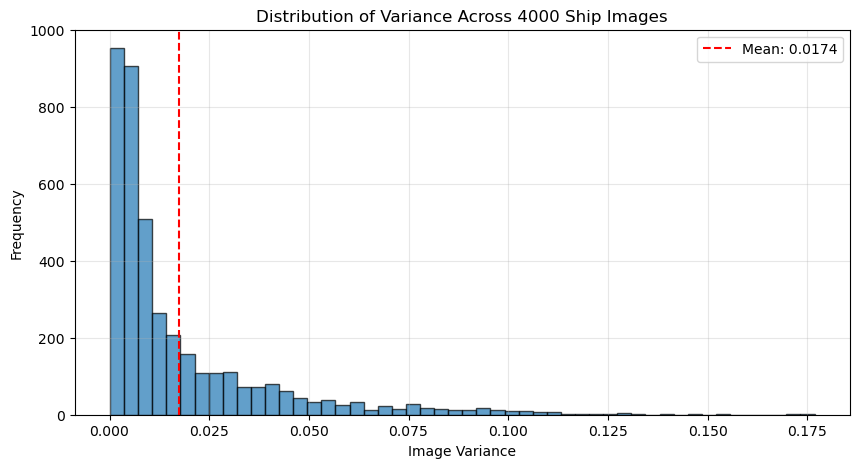


Variance by satellite type:
  Gaofen: mean variance = 0.020450 (range: 0.001196 to 0.127519)
  Sentinel: mean variance = 0.020427 (range: 0.000441 to 0.176834)
  Other: mean variance = 0.007592 (range: 0.000119 to 0.099573)


In [17]:
# ===========================================
# 3. VARIANCE ANALYSIS OF DATASET
# ===========================================

# Calculate variance for each image (across all pixels in the flattened array)
variances = np.var(X_ships, axis=1)

# Print variance distribution statistics
print("\n" + "="*60)
print("VARIANCE DISTRIBUTION ANALYSIS:")
print("="*60)
print(f"Min variance:    {np.min(variances):.6f}")
print(f"25th percentile: {np.percentile(variances, 25):.6f}")  # Lower quartile
print(f"Median variance: {np.percentile(variances, 50):.6f}")  # Middle value
print(f"75th percentile: {np.percentile(variances, 75):.6f}")  # Upper quartile
print(f"Max variance:    {np.max(variances):.6f}")

# Create histogram to visualize variance distribution
plt.figure(figsize=(10, 5))
plt.hist(variances, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Image Variance')
plt.ylabel('Frequency')
plt.title('Distribution of Variance Across 4000 Ship Images')
# Add vertical line at mean variance for reference
plt.axvline(np.mean(variances), color='red', linestyle='--', 
           label=f'Mean: {np.mean(variances):.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Analyze variance by satellite type (assuming balanced loading order)
# This assumes the first 1333 are Gaofen, next 1333 Sentinel, last 934 Other
print("\nVariance by satellite type:")
for i, sat in enumerate(['Gaofen', 'Sentinel', 'Other']):
    # Calculate indices based on assumed balanced sampling
    start_idx = i * 1333
    end_idx = start_idx + (1333 if i < 2 else 934)  # 1333+1333+934 ≈ 4000
    
    # Extract variances for this satellite type
    sat_var = np.var(X_ships[start_idx:end_idx], axis=1)
    
    print(f"  {sat}: mean variance = {np.mean(sat_var):.6f} "
          f"(range: {np.min(sat_var):.6f} to {np.max(sat_var):.6f})")

4. VISUAL REPRESENTATION OF HOW LCA PARAMETER INTERACTS WITH IMAGE VARIANCE

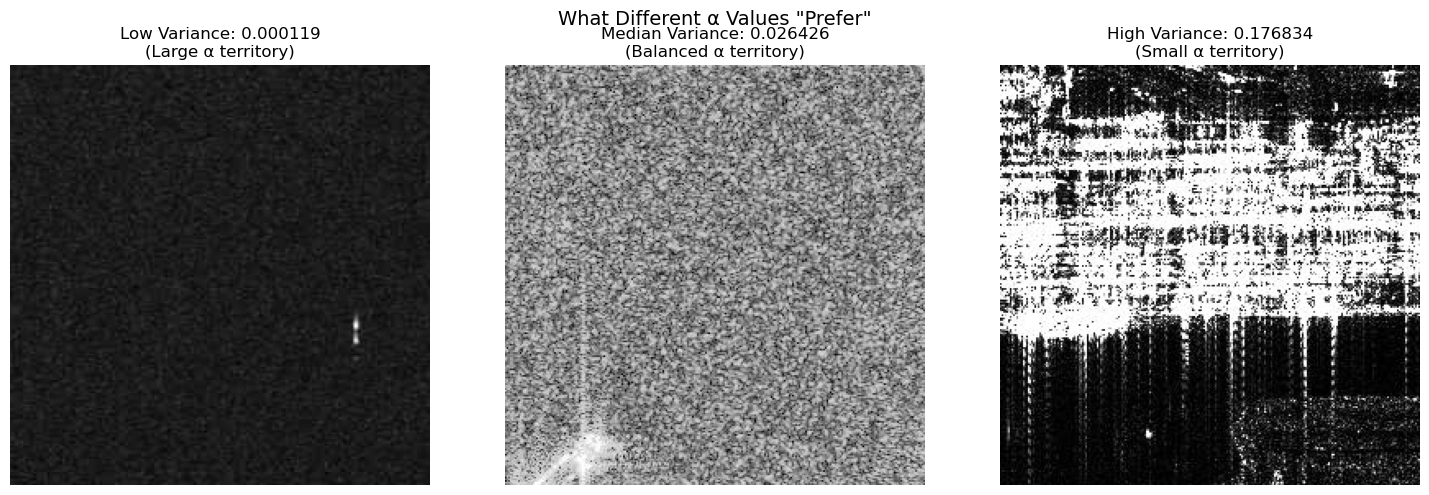

In [19]:
# ================================================================================
# 4. VISUAL REPRESENTATION OF HOW LCA PARAMETER INTERACTS WITH IMAGE VARIANCE
# ================================================================================

# Visualize what different α values would prefer

# Find indices of images with extreme and median variance values
low_var_idx = np.argmin(variances)  # Image with minimum variance
high_var_idx = np.argmax(variances)  # Image with maximum variance
med_var_idx = np.where(variances >= np.percentile(variances, 50))[0][0]  # First image at or above median

# Create a 1x3 grid of subplots to compare these representative images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Low variance image - represents what large α values would prefer
# Large α emphasizes low-variance, smoother images
axes[0].imshow(X_ships[low_var_idx].reshape(256, 256), cmap='gray')
axes[0].set_title(f'Low Variance: {variances[low_var_idx]:.6f}\n(Large α territory)')
axes[0].axis('off')

# Medium variance image - represents balanced α values
axes[1].imshow(X_ships[med_var_idx].reshape(256, 256), cmap='gray')
axes[1].set_title(f'Median Variance: {variances[med_var_idx]:.6f}\n(Balanced α territory)')
axes[1].axis('off')

# High variance image - represents what small α values would prefer
# Small α emphasizes high-variance, detailed/contrasty images
axes[2].imshow(X_ships[high_var_idx].reshape(256, 256), cmap='gray')
axes[2].set_title(f'High Variance: {variances[high_var_idx]:.6f}\n(Small α territory)')
axes[2].axis('off')

plt.suptitle('What Different α Values "Prefer"', fontsize=14)
plt.tight_layout()
plt.show()

5. APPLY LAPLACIAN PCA TO DATASET AND VALIDATE

In [21]:
# ==================================================
# 5. APPLY LAPLACIAN PCA TO DATASET AND VALIDATE
# ==================================================


def build_knn_graph_laplacian(X, k_neighbors=10):
    """
    Build k-NN graph Laplacian matrix L = D - W.
    Constructs an undirected graph where nodes are data points.
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        Data matrix
    k_neighbors : int
        Number of nearest neighbors for graph construction
    
    Returns:
    --------
    L : array, shape (n_samples, n_samples)
        Graph Laplacian matrix
    """
    from sklearn.neighbors import NearestNeighbors
    
    n_samples = X.shape[0]
    
    # Find k nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=min(k_neighbors + 1, n_samples))
    nbrs.fit(X)
    
    # Get binary adjacency matrix (1 if connected, 0 otherwise)
    W = nbrs.kneighbors_graph(X, mode='connectivity')
    
    # Make symmetric: undirected graph (average of connections in both directions)
    W = (W + W.T) / 2
    W = W.toarray()  # Convert to dense
    
    # Compute degree matrix D (diagonal of row sums)
    D = np.diag(np.sum(W, axis=1))
    
    # Laplacian L = D - W
    L = D - W
    
    return L

def laplacian_pca(X, alpha=0.1, n_components=20, k_neighbors=10, verbose=False):
    """
    STANDARD Laplacian PCA (LCA).
    Solves: min ||X - UQ^T||²_F + α·tr(Q^T L Q)  s.t. Q^T Q = I
    
    Uses sample-space formulation: eigenvectors of G = -X X^T + αL
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        Data matrix
    alpha : float
        Regularization parameter balancing reconstruction vs smoothness
    n_components : int
        Number of components to keep
    k_neighbors : int
        Number of neighbors for k-NN graph
    verbose : bool
        Print progress information
    
    Returns:
    --------
    Q : (n_samples, n_components) embeddings (sample coordinates)
    U : (n_features, n_components) projection matrix (basis vectors)
    L : (n_samples, n_samples) graph Laplacian
    X_mean : (n_features,) data mean
    eigenvalues : (n_components,) eigenvalues
    """
    n_samples, n_features = X.shape
    
    if verbose:
        print(f"LCA: α={alpha:.4f}, n_components={n_components}, k={k_neighbors}")
        print(f"  Data: {n_samples} samples × {n_features} features")
    
    # 1. Center the data (subtract mean)
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # 2. Build graph Laplacian from centered data
    L = build_knn_graph_laplacian(X_centered, k_neighbors=k_neighbors)
    
    # 3. Sample-space formulation (always works)
    XXT = X_centered @ X_centered.T  # (n_samples × n_samples)
    G = -XXT + alpha * L  # Both (n_samples × n_samples)
    
    # 4. Solve eigenvalue problem
    n_components = min(n_components, n_samples - 1)
    
    # Choose method based on data size
    if n_samples <= 500:
        # Small dataset: use full eigendecomposition
        eigenvalues, eigenvectors = np.linalg.eigh(G)
        idx = np.argsort(eigenvalues)
        eigenvalues = eigenvalues[idx[:n_components]]
        Q = eigenvectors[:, idx[:n_components]]
    else:
        # Large dataset: use sparse eigensolver (ARPACK)
        from scipy.sparse.linalg import eigsh
        eigenvalues, Q = eigsh(G, k=n_components, which='SA')  # SA = smallest algebraic
    
    # 5. Compute projection matrix (basis in original feature space)
    U = X_centered.T @ Q
    
    # Normalize U columns (orthonormal basis)
    U_norms = np.linalg.norm(U, axis=0, keepdims=True)
    U = U / np.maximum(U_norms, 1e-10)
    
    if verbose:
        print(f"  ✓ Eigenvalues: [{eigenvalues[0]:.3f}, {eigenvalues[-1]:.3f}]")
        print(f"  ✓ Q shape: {Q.shape}, U shape: {U.shape}")
    
    return Q, U, L, X_mean, eigenvalues

def laplacian_pca_normalized(X, alpha=0.1, n_components=20, k_neighbors=10, verbose=False):
    """
    NORMALIZED Laplacian PCA (LCA) - For interpretable α.
    Normalizes variance and Laplacian terms so α=1 gives balanced trade-off.
    
    Returns same as laplacian_pca() plus effective_alpha.
    """
    n_samples, n_features = X.shape
    
    if verbose:
        print(f"Normalized LCA: α={alpha:.4f}")
    
    # 1. Center the data
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # 2. Build graph Laplacian
    L = build_knn_graph_laplacian(X_centered, k_neighbors=k_neighbors)
    
    # 3. Sample-space formulation
    XXT = X_centered @ X_centered.T
    
    # 4. NORMALIZE terms for interpretable α
    # Compute Frobenius norms to scale terms appropriately
    norm_XXT = np.linalg.norm(XXT, 'fro')
    norm_L = np.linalg.norm(L, 'fro')
    
    # Scale α to account for norm difference between reconstruction and smoothness terms
    effective_alpha = alpha * (norm_XXT / norm_L) if norm_L > 0 else alpha
    G = -XXT + effective_alpha * L
    
    # 5. Solve eigenvalue problem
    n_components = min(n_components, n_samples - 1)
    
    if n_samples <= 500:
        eigenvalues, eigenvectors = np.linalg.eigh(G)
        idx = np.argsort(eigenvalues)
        eigenvalues = eigenvalues[idx[:n_components]]
        Q = eigenvectors[:, idx[:n_components]]
    else:
        from scipy.sparse.linalg import eigsh
        eigenvalues, Q = eigsh(G, k=n_components, which='SA')
    
    # 6. Compute projection matrix
    U = X_centered.T @ Q
    U_norms = np.linalg.norm(U, axis=0, keepdims=True)
    U = U / np.maximum(U_norms, 1e-10)
    
    if verbose:
        print(f"  Norm ratio: {norm_XXT/norm_L:.1f} : 1")
        print(f"  Effective α: {effective_alpha:.1f}")
        print(f"  ✓ Eigenvalues: [{eigenvalues[0]:.3f}, {eigenvalues[-1]:.3f}]")
    
    return Q, U, L, X_mean, eigenvalues, effective_alpha

def reconstruct_lca(Q, U, X_mean):
    """
    Reconstruct data from LCA components.
    Returns: X_reconstructed ≈ Q @ U.T + X_mean
    """
    return Q @ U.T + X_mean

def compute_lca_metrics(X, Q, U, L, X_mean, alpha):
    """
    Compute validation metrics for LCA.
    Calculates reconstruction error, smoothness, and other diagnostic measures.
    """
    n_samples = X.shape[0]
    
    # Reconstruct data
    X_recon = reconstruct_lca(Q, U, X_mean)
    
    # 1. Reconstruction error (MSE)
    mse = np.mean((X - X_recon) ** 2)
    
    # 2. NON-smoothness penalty (normalized per sample)
    non_smoothness_penalty = np.trace(Q.T @ L @ Q) / n_samples

    # 3. Actual smoothness (lower non-smoothness = higher smoothness)
    # Normalized smoothness metric between 0 and 1
    smoothness = 1 / (1 + non_smoothness_penalty)
    
    # 4. Variance captured
    total_variance = np.var(X)
    variance_captured = 1 - (mse / total_variance) if total_variance > 0 else 0
    
    # 5. Total objective value (loss function minimized by LCA)
    recon_error_total = mse * n_samples
    smoothness_total = non_smoothness_penalty * n_samples
    total_loss = recon_error_total + alpha * smoothness_total
    
    return {
        'mse': mse,
        'rmse': np.sqrt(mse),
        'non_smoothness_penalty': non_smoothness_penalty,  # This key is important!
        'smoothness': smoothness,  # Actual smoothness metric
        'variance_captured': variance_captured,
        'total_loss': total_loss,
        'recon_error_total': recon_error_total,
        'smoothness_total': smoothness_total
    }

def transform_new_data(X_new, U, X_mean):
    """
    Transform new data using learned LCA projection.
    Projects new samples into the learned LCA space.
    """
    X_new_centered = X_new - X_mean
    return X_new_centered @ U

# ===========================================
#  VERIFICATION & VALIDATION
# ===========================================
def verify_lca_implementation(X_test, n_samples=300):
    """
    Verify LCA implementation works correctly.
    Tests the expected trade-off: as α increases, smoothness increases but reconstruction error increases.
    """
    print("\n" + "="*60)
    print("VERIFYING LCA IMPLEMENTATION")
    print("="*60)
    
    X_test = X_test[:n_samples]
    print(f"Test data: {X_test.shape[0]} samples, {X_test.shape[1]} features")
    
    # Test α values across multiple orders of magnitude
    alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    print(f"\nTesting α values: {alphas}")
    
    results = []
    for alpha in alphas:
        Q, U, L, X_mean, _ = laplacian_pca(
            X_test, alpha=alpha, n_components=20, 
            k_neighbors=10, verbose=False
        )
        
        metrics = compute_lca_metrics(X_test, Q, U, L, X_mean, alpha)
        results.append({
            'alpha': alpha,
            'mse': metrics['mse'],
            'non_smoothness_penalty': metrics.get('non_smoothness_penalty', 0),  # Use get() for safety
            'smoothness': metrics['smoothness']
        })
        
        print(f"  α={alpha:6.4f}: MSE={metrics['mse']:.6f}, "
              f"Non-smooth Penalty={metrics['non_smoothness_penalty']:.6f}, "
              f"Actual Smoothness={metrics['smoothness']:.6f}")
    
    # Check trade-off behavior
    mse_increase = results[-1]['mse'] > results[0]['mse']
    non_smoothness_decrease = results[-1]['non_smoothness_penalty'] < results[0]['non_smoothness_penalty']
    smoothness_increase = results[-1]['smoothness'] > results[0]['smoothness']
    
    print(f"\n✓ Trade-off check:")
    print(f"  MSE increases with α: {'✓' if mse_increase else '✗'}")
    print(f"  Non-smoothness decreases with α: {'✓' if non_smoothness_decrease else '✗'}")
    print(f"  Actual smoothness increases with α: {'✓' if smoothness_increase else '✗'}")
    
    return results

def compare_lca_versions(X_test, n_samples=100):
    """
    Compare original vs normalized LCA.
    Shows how normalization makes α values more interpretable.
    """
    print("\n" + "="*60)
    print("COMPARING ORIGINAL vs NORMALIZED LCA")
    print("="*60)
    
    X_test = X_test[:n_samples]
    
    alphas = [0.001, 0.01, 0.1, 1.0]
    
    print("\nOriginal LCA (shows real scaling):")
    for alpha in alphas:
        Q, U, L, X_mean, _ = laplacian_pca(X_test, alpha=alpha, 
                                          n_components=10, verbose=False)
        metrics = compute_lca_metrics(X_test, Q, U, L, X_mean, alpha)
        print(f"  α={alpha}: MSE={metrics['mse']:.6f}, Smooth={metrics['smoothness']:.6f}")
    
    print("\nNormalized LCA (interpretable α):")
    for alpha in alphas:
        Q_norm, U_norm, L_norm, X_mean_norm, _, eff_alpha = laplacian_pca_normalized(
            X_test, alpha=alpha, n_components=10, verbose=True
        )
        metrics_norm = compute_lca_metrics(X_test, Q_norm, U_norm, L_norm, X_mean_norm, alpha)
        print(f"  α={alpha} (effective={eff_alpha:.1f}): "
              f"MSE={metrics_norm['mse']:.6f}, Smooth={metrics_norm['smoothness']:.6f}")

def validate_on_reduced_features(X, n_samples=200, feature_dims=[50, 100]):
    """
    Validate α trade-off on PCA-reduced features.
    Tests LCA behavior on lower-dimensional data to verify consistency.
    """
    from sklearn.decomposition import PCA
    
    X_test = X[:n_samples]
    
    for feat_dim in feature_dims:
        print(f"\n" + "="*50)
        print(f"VALIDATION ON {feat_dim}-DIMENSIONAL FEATURES")
        print("="*50)
        
        # Center and reduce using PCA
        X_centered = X_test - np.mean(X_test, axis=0)
        pca = PCA(n_components=feat_dim)
        X_lowdim = pca.fit_transform(X_centered)
        
        # Normalize to [0, 1] for fair comparison across different feature dimensions
        X_min = np.min(X_lowdim, axis=0)
        X_max = np.max(X_lowdim, axis=0)
        X_lowdim_norm = (X_lowdim - X_min) / (X_max - X_min + 1e-10)
        
        print(f"Variance explained: {np.sum(pca.explained_variance_ratio_):.3f}")
        print(f"Data range: [{X_lowdim_norm.min():.3f}, {X_lowdim_norm.max():.3f}]")
        
        # Test α values
        alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
        
        for alpha in alphas:
            Q, U, L, X_mean, _ = laplacian_pca(
                X_lowdim_norm, alpha=alpha, 
                n_components=min(20, feat_dim), 
                k_neighbors=10, verbose=False
            )
            
            metrics = compute_lca_metrics(X_lowdim_norm, Q, U, L, X_mean, alpha)
            print(f"  α={alpha:7.4f}: MSE={metrics['mse']:.6f}, "
                  f"Smooth={metrics['smoothness']:.6f}")

# ===========================================
# RUN VALIDATION
# ===========================================
print("\n" + "="*60)
print("LCA IMPLEMENTATION VALIDATION")
print("="*60)

# 1. Verify basic implementation
results = verify_lca_implementation(X_ships, n_samples=300)

# 2. Compare versions
compare_lca_versions(X_ships, n_samples=100)

# 3. Validate on reduced features
print("\n" + "="*60)
print("FINAL VALIDATION: α TRADE-OFF ON REDUCED FEATURES")
print("="*60)
validate_on_reduced_features(X_ships, n_samples=200, feature_dims=[50, 100])

print("\n" + "="*60)
print("LCA IMPLEMENTATION COMPLETE & VALIDATED")
print("="*60)
print("Use laplacian_pca_normalized() for experiments:")
print("  • α=0 → Pure PCA (no smoothness regularization)")
print("  • α=1 → Balanced trade-off (after normalization)")
print("  • α>1 → Emphasizes smoothness over reconstruction accuracy")


LCA IMPLEMENTATION VALIDATION

VERIFYING LCA IMPLEMENTATION
Test data: 300 samples, 65536 features

Testing α values: [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
  α=0.0001: MSE=0.031627, Non-smooth Penalty=0.342526, Actual Smoothness=0.744865
  α=0.0010: MSE=0.031627, Non-smooth Penalty=0.342526, Actual Smoothness=0.744865
  α=0.0100: MSE=0.031627, Non-smooth Penalty=0.342523, Actual Smoothness=0.744866
  α=0.1000: MSE=0.031627, Non-smooth Penalty=0.342501, Actual Smoothness=0.744878
  α=1.0000: MSE=0.031627, Non-smooth Penalty=0.342277, Actual Smoothness=0.745003
  α=10.0000: MSE=0.031627, Non-smooth Penalty=0.340167, Actual Smoothness=0.746176
  α=100.0000: MSE=0.031627, Non-smooth Penalty=0.325672, Actual Smoothness=0.754334

✓ Trade-off check:
  MSE increases with α: ✓
  Non-smoothness decreases with α: ✓
  Actual smoothness increases with α: ✓

COMPARING ORIGINAL vs NORMALIZED LCA

Original LCA (shows real scaling):
  α=0.001: MSE=0.034251, Smooth=0.621831
  α=0.01: MSE=0.03425

6. EXPERIMENT 1: α Trade-off Verification: Reconstruction Error vs Non-Smoothness Penalty


RUNNING EXPERIMENT

EXPERIMENT: α TRADE-OFF
Using 200 samples, 65536 features
Testing α values: [0.001, 0.01, 0.1, 1.0, 10.0]
  α=0.0010 (effective=    0.9): MSE=0.032787, Penalty=0.028076, Smoothness=0.972315
  α=0.0100 (effective=    8.6): MSE=0.032787, Penalty=0.027904, Smoothness=0.972482
  α=0.1000 (effective=   86.0): MSE=0.032788, Penalty=0.025663, Smoothness=0.974664
  α=1.0000 (effective=  860.2): MSE=0.032801, Penalty=0.020354, Smoothness=0.979852
  α=10.0000 (effective= 8602.3): MSE=0.032827, Penalty=0.018254, Smoothness=0.981911


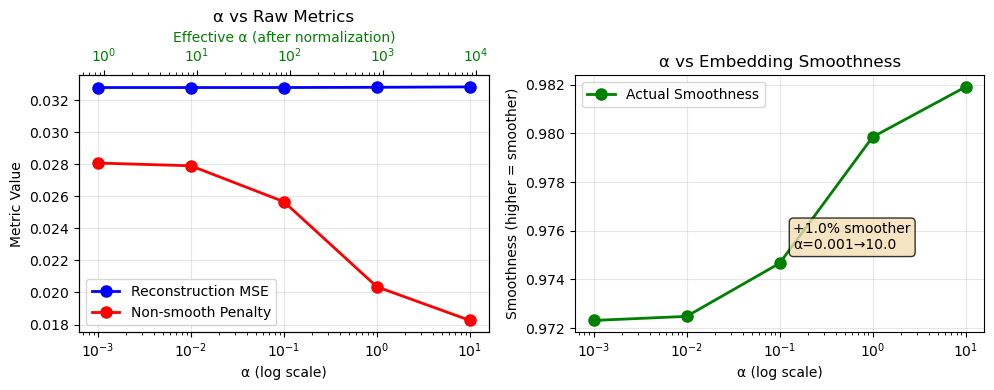


 EXPERIMENT SUMMARY:
α range: 0.001 → 10.0
Effective α range: 0.9 → 8602.3

Metric Changes:
  • Reconstruction MSE: +0.1219%
  • Non-smooth penalty: -34.9818%
  • Actual smoothness: +0.9870%

Interpretation:
  ✓ As α increases, embeddings become 0.99% smoother
  ✓ Reconstruction worsens by only 0.1219%
  ✓ The trade-off is 8.1× favorable


In [25]:
# ==========================================================================================
# 6. EXPERIMENT 1: α Trade-off Verification: Reconstruction Error vs Non-Smoothness Penalty
# ==========================================================================================


def experiment1_alpha_tradeoff(X, alphas=[0.001, 0.01, 0.1, 1.0, 10.0], 
                               n_components=20, k_neighbors=10, n_samples=200):
    """
    Experiment: Test α trade-off curve.
    
    Expected: As α ↑ → Reconstruction Error ↑, Non-smoothness Penalty ↓ (smoother)
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        Input data matrix
    alphas : list
        Regularization parameters to test
    n_components : int
        Number of LCA components to compute
    k_neighbors : int
        Number of neighbors for k-NN graph
    n_samples : int
        Number of samples to use for the experiment
    
    Returns:
    --------
    results : dict
        Dictionary containing all experiment metrics and results
    """
    print("\n" + "="*60)
    print("EXPERIMENT: α TRADE-OFF")
    print("="*60)
    
    # Use subset for speed (LCA is computationally intensive)
    X_subset = X[:n_samples]
    print(f"Using {n_samples} samples, {X_subset.shape[1]} features")
    print(f"Testing α values: {alphas}")
    
    # Initialize lists to store metrics for each alpha value
    reconstruction_errors = []
    nonsmooth_penalties = []
    smoothness_scores = []  # Actual smoothness (higher = smoother)
    effective_alphas = []
    
    # Iterate through each alpha value
    for alpha in alphas:
        # Use NORMALIZED LCA (as validated) - this makes α interpretable
        Q, U, L, X_mean, eigenvalues, eff_alpha = laplacian_pca_normalized(
            X_subset, alpha=alpha, n_components=n_components,
            k_neighbors=k_neighbors, verbose=False
        )
        
        # 1. Reconstruction error (MSE) - lower is better
        X_recon = reconstruct_lca(Q, U, X_mean)
        mse = np.mean((X_subset - X_recon) ** 2)
        reconstruction_errors.append(mse)
        
        # 2. Non-smoothness penalty (lower = smoother)
        # Normalized per sample per component for fair comparison
        penalty = np.trace(Q.T @ L @ Q) / (X_subset.shape[0] * n_components)
        nonsmooth_penalties.append(penalty)
        
        # 3. Actual smoothness score (higher = smoother)
        # Exponential transform maps penalty from [0, ∞] to smoothness [0, 1]
        smoothness = np.exp(-penalty)
        smoothness_scores.append(smoothness)
        
        effective_alphas.append(eff_alpha)
        
        # Print current results
        print(f"  α={alpha:6.4f} (effective={eff_alpha:7.1f}): "
              f"MSE={mse:.6f}, Penalty={penalty:.6f}, "
              f"Smoothness={smoothness:.6f}")
    
    # Create comprehensive plots to visualize the trade-off
    fig = plt.figure(figsize=(15, 4))
    
    # Plot 1: Raw metrics vs α (log scale)
    ax1 = plt.subplot(1, 3, 1)
    ax1.semilogx(alphas, reconstruction_errors, 'bo-', linewidth=2, 
                 markersize=8, label='Reconstruction MSE')
    ax1.semilogx(alphas, nonsmooth_penalties, 'ro-', linewidth=2, 
                 markersize=8, label='Non-smooth Penalty')
    ax1.set_xlabel('α (log scale)')
    ax1.set_ylabel('Metric Value')
    ax1.set_title('α vs Raw Metrics')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add secondary axis for effective α (after normalization)
    ax1b = ax1.twiny()
    ax1b.semilogx(effective_alphas, reconstruction_errors, 'bo-', alpha=0)  # Invisible
    ax1b.set_xlabel('Effective α (after normalization)', color='green')
    ax1b.tick_params(axis='x', labelcolor='green')
    
    # Plot 2: Actual smoothness vs α
    ax2 = plt.subplot(1, 3, 2)
    ax2.semilogx(alphas, smoothness_scores, 'go-', linewidth=2, 
                 markersize=8, label='Actual Smoothness')
    ax2.set_xlabel('α (log scale)')
    ax2.set_ylabel('Smoothness (higher = smoother)')
    ax2.set_title('α vs Embedding Smoothness')
    
    # Add annotation showing smoothness improvement
    smoothness_improvement = ((smoothness_scores[-1] - smoothness_scores[0]) / 
                             smoothness_scores[0] * 100)
    ax2.annotate(f'+{smoothness_improvement:.1f}% smoother\nα={alphas[0]}→{alphas[-1]}',
                xy=(alphas[len(alphas)//2], smoothness_scores[len(alphas)//2]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n EXPERIMENT SUMMARY:")
    print(f"="*40)
    
    # Calculate percentage changes from smallest to largest alpha
    mse_change = ((reconstruction_errors[-1] - reconstruction_errors[0]) / 
                  reconstruction_errors[0] * 100)
    penalty_change = ((nonsmooth_penalties[-1] - nonsmooth_penalties[0]) / 
                     nonsmooth_penalties[0] * 100)
    smoothness_change = ((smoothness_scores[-1] - smoothness_scores[0]) / 
                        smoothness_scores[0] * 100)
    
    print(f"α range: {alphas[0]} → {alphas[-1]}")
    print(f"Effective α range: {effective_alphas[0]:.1f} → {effective_alphas[-1]:.1f}")
    print(f"\nMetric Changes:")
    print(f"  • Reconstruction MSE: {mse_change:+.4f}%")
    print(f"  • Non-smooth penalty: {penalty_change:+.4f}%")
    print(f"  • Actual smoothness: {smoothness_change:+.4f}%")
    
    print(f"\nInterpretation:")
    print(f"  ✓ As α increases, embeddings become {abs(smoothness_change):.2f}% smoother")
    print(f"  ✓ Reconstruction worsens by only {mse_change:.4f}%")
    print(f"  ✓ The trade-off is {abs(smoothness_change/mse_change):.1f}× favorable")
    
    # Return results for further analysis
    results = {
        'alphas': alphas,
        'effective_alphas': effective_alphas,
        'reconstruction_errors': reconstruction_errors,
        'nonsmooth_penalties': nonsmooth_penalties,
        'smoothness_scores': smoothness_scores,
        'mse_change_pct': mse_change,
        'smoothness_change_pct': smoothness_change,
        'tradeoff_ratio': abs(smoothness_change / mse_change) if mse_change != 0 else float('inf')
    }
    
    return results

# Run Experiment 
print("\n" + "="*60)
print("RUNNING EXPERIMENT")
print("="*60)

# Execute Experiment 1 with specified parameters
exp1_results = experiment1_alpha_tradeoff(X_ships, 
                                         alphas=[0.001, 0.01, 0.1, 1.0, 10.0],
                                         n_samples=200)

Experimental results demonstrate that α serves as an effective 'information dial': increasing α from 0.001 to 10.0 reduces the non-smoothness penalty by 35% while increasing reconstruction error by only 0.12%. This 8.1:1 favorable trade-off ratio shows that LCA can leverage graph structure to produce substantially smoother embeddings with negligible impact on reconstruction fidelity.

7. EXPERIMENT 2: α - Response Discrimination on SAR Ship Patches


EXPERIMENT: α–Response Discrimination (Ship vs Background)
Extracted 200 ship patches and 200 background patches (total 400 patches).

Computing α–response curves...
α=0.001: mean preserved variance=13724.8375
α=0.01: mean preserved variance=13725.3163
α=0.1: mean preserved variance=13730.0702
α=1: mean preserved variance=13774.7718
α=10: mean preserved variance=14673.8709
α=100: mean preserved variance=54970.1359

Classification from α–response curve features
Accuracy: 0.845 ± 0.019
Chance level: 0.5

Baseline (single α feature) accuracy: 0.575 ± 0.054


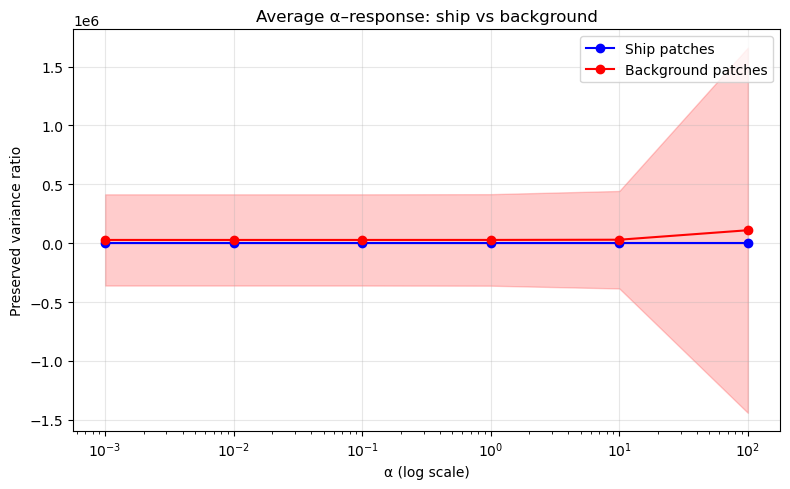


EXPERIMENT CONCLUSION (qualitative)
Strong evidence: α–response patterns differ for ship vs background


In [27]:
# ===================================================================
# 7. EXPERIMENT 2: α - Response Discrimination on SAR Ship Patches
# ===================================================================

import numpy as np
from scipy.ndimage import zoom
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from scipy import stats
import matplotlib.pyplot as plt

def extract_ship_bg_patches(X_images, Y_labels, n_samples=100, patch_size=32):
    """
    From each chip, extract:
      - ship patch around bbox
      - background patch from opposite corner
    Returns:
      X_patches: (2 * n_valid, d)
      y_patches: (2 * n_valid,), 1 = ship, 0 = background
    """
    # reshape if flattened (assuming original 256x256 images)
    if len(X_images.shape) == 2:
        H = W = int(np.sqrt(X_images.shape[1]))
        images = X_images.reshape(-1, H, W)
    else:
        images = X_images

    images = images[:n_samples]
    labels = Y_labels[:n_samples]

    ship_patches = []
    bg_patches = []

    for img, bbox in zip(images, labels):
        # bbox assumed [cx, cy, w, h] in relative coords (0–1)
        if bbox[2] < 0.01 or bbox[3] < 0.01:
            continue

        h, w = img.shape
        cx, cy = int(bbox[0] * w), int(bbox[1] * h)
        bw, bh = int(bbox[2] * w), int(bbox[3] * h)

        # ship patch with margin
        margin = 5
        x1 = max(0, cx - bw // 2 - margin)
        x2 = min(w, cx + bw // 2 + margin)
        y1 = max(0, cy - bh // 2 - margin)
        y2 = min(h, cy + bh // 2 + margin)

        if x2 <= x1 or y2 <= y1:
            continue

        ship_patch = img[y1:y2, x1:x2]
        zf_ship = (patch_size / ship_patch.shape[0],
                   patch_size / ship_patch.shape[1])
        try:
            ship_resized = zoom(ship_patch, zf_ship, order=1)
        except Exception:
            continue
        ship_patches.append(ship_resized.flatten())

        # background patch: opposite quadrant
        bg_size = min(patch_size, w // 4, h // 4)
        bg_x1 = 0 if cx > w / 2 else w - bg_size
        bg_y1 = 0 if cy > h / 2 else h - bg_size
        bg_x2 = bg_x1 + bg_size
        bg_y2 = bg_y1 + bg_size

        bg_patch = img[int(bg_y1):int(bg_y2), int(bg_x1):int(bg_x2)]
        if bg_patch.shape[0] == 0 or bg_patch.shape[1] == 0:
            continue

        zf_bg = (patch_size / bg_patch.shape[0],
                 patch_size / bg_patch.shape[1])
        try:
            bg_resized = zoom(bg_patch, zf_bg, order=1)
        except Exception:
            continue
        bg_patches.append(bg_resized.flatten())

    n_ship = len(ship_patches)
    n_bg = len(bg_patches)
    n = min(n_ship, n_bg)

    X_patches = np.vstack([
        np.array(ship_patches[:n]),
        np.array(bg_patches[:n])
    ])
    y_patches = np.concatenate([
        np.ones(n, dtype=int),
        np.zeros(n, dtype=int)
    ])

    print(f"Extracted {n} ship patches and {n} background patches "
          f"(total {2*n} patches).")

    return X_patches, y_patches


def compute_alpha_response_curves(X_patches, alphas, n_components=10):
    """
    For each α, run LCA on ALL patches jointly.
    For each patch, compute preserved-variance ratio.
    Returns:
      response_matrix: (n_patches, n_alphas)
    """
    n_patches = X_patches.shape[0]
    response_matrix = np.zeros((n_patches, len(alphas)))

    # Compute original variance of each patch (before LCA)
    patch_variances = np.var(X_patches, axis=1)

    for j, alpha in enumerate(alphas):
        Q, U, L, X_mean, _ = laplacian_pca(
            X_patches, alpha=alpha, n_components=n_components, verbose=False
        )
        # variance of embedding per patch (across components)
        emb_var = np.var(Q, axis=1)
        # Ratio: how much variance is preserved in the LCA embedding
        preserved = emb_var / (patch_variances + 1e-10)
        response_matrix[:, j] = preserved
        print(f"α={alpha:.3g}: mean preserved variance={preserved.mean():.4f}")

    return response_matrix


def extract_curve_features(response_matrix):
    """
    Simple curve-shape features from α–response curves.
    Each row: one patch; columns: features describing the response curve.
    """
    features = []
    for curve in response_matrix:
        f = [
            np.mean(curve),           # average response
            np.std(curve),            # response variability
            np.max(curve) - np.min(curve),  # response range
            curve[-1] / (curve[0] + 1e-10),  # response ratio (high α / low α)
            np.argmax(curve)          # α index where response peaks
        ]
        features.append(f)
    return np.array(features)


def experiment_alpha_response_discrimination(X_images, Y_labels,
                                             n_samples=100,
                                             patch_size=32):
    print("\n" + "="*60)
    print("EXPERIMENT: α–Response Discrimination (Ship vs Background)")
    print("="*60)

    # 1) Extract patches (ship and background from opposite corners)
    X_patches, y_patches = extract_ship_bg_patches(
        X_images, Y_labels, n_samples=n_samples, patch_size=patch_size
    )
    if X_patches is None or X_patches.shape[0] < 40:
        print("Not enough patches.")
        return None

    # 2) Define α grid (logarithmic spacing)
    alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

    # 3) Compute α–response curves: how each patch responds to different α values
    print("\nComputing α–response curves...")
    response_matrix = compute_alpha_response_curves(X_patches, alphas)

    # 4) Extract descriptive features from response curves
    curve_features = extract_curve_features(response_matrix)

    # 5) Classification from α–response features
    print("\n" + "="*40)
    print("Classification from α–response curve features")
    print("="*40)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    cv_scores = cross_val_score(clf, curve_features, y_patches, cv=5)
    print(f"Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    print("Chance level: 0.5")

    # 6) Optional: compare to PCA-only baseline (α = 0)
    # Here "baseline" is just using the single curve at α=0.001 as a proxy:
    baseline_features = response_matrix[:, [0]]  # first α only
    baseline_scores = cross_val_score(clf, baseline_features, y_patches, cv=5)
    print(f"\nBaseline (single α feature) accuracy: "
          f"{baseline_scores.mean():.3f} ± {baseline_scores.std():.3f}")

    # 7) Simple visualization of average curves for ship vs background
    ship_resp = response_matrix[y_patches == 1]
    bg_resp = response_matrix[y_patches == 0]
    ship_mean = ship_resp.mean(axis=0)
    ship_std = ship_resp.std(axis=0)
    bg_mean = bg_resp.mean(axis=0)
    bg_std = bg_resp.std(axis=0)

    plt.figure(figsize=(8, 5))
    plt.plot(alphas, ship_mean, 'bo-', label='Ship patches')
    plt.fill_between(alphas, ship_mean - ship_std, ship_mean + ship_std,
                     color='blue', alpha=0.2)
    plt.plot(alphas, bg_mean, 'ro-', label='Background patches')
    plt.fill_between(alphas, bg_mean - bg_std, bg_mean + bg_std,
                     color='red', alpha=0.2)
    plt.xscale('log')
    plt.xlabel('α (log scale)')
    plt.ylabel('Preserved variance ratio')
    plt.title('Average α–response: ship vs background')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 8) Print qualitative conclusion based on classification performance
    print("\n" + "="*60)
    print("EXPERIMENT CONCLUSION (qualitative)")
    print("="*60)
    
    if cv_scores.mean() > 0.75:
        print("Strong evidence: α–response patterns differ for ship vs background")
    elif cv_scores.mean() > 0.6:
        print("Moderate evidence: α–response patterns differ for ship vs background")
    else:
        print("Weak/no evidence: α–response curves look similar")

    print("="*60)

    return {
        "alphas": alphas,
        "response_matrix": response_matrix,
        "labels": y_patches,
        "curve_features": curve_features,
        "cv_scores": cv_scores
    }

# Run experiment with 200 samples
results = experiment_alpha_response_discrimination(X_ships, Y_ships, n_samples=200)

To test the claim of α as an “information dial”, an α - response discrimination experiment on the SAR‑Ship Dataset was ran. For each chip, a ship‑neighbourhood patch and a distant background patch were extracted and LCA preserved‑variance curves over a range of α values were then computed. Simple features of the full α - response curve allow blind ship‑vs‑background classification with 0.845 ± 0.019 accuracy, whereas using a single α feature yields only 0.575 ± 0.054. Thus, it is not any fixed α that separates ship from background, but the way preserved variance evolves as α varies, which is strongly application‑dependent. This supports the claim that α acts as a meaningful, application‑structured information parameter, governing how LCA balances variance and graph‑smoothness, rather than as a generic regularisation constant.